#Transfer Learning For Image Classification
In this notebook we use pre-trained resnet18 Convolutional Network.<br>

We have used the tutorials:
* "Quickstart tutorial" https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
*  "TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL", link: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html<br>


Notice: All weights are trainable, only initialized with a pretrained network, like the one that is trained on ImageNet, which contains 1.2 million images with 1000 categories.



###Import Packages

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
from imutils import paths
import shutil
import re

plt.ion()   # interactive mode

###Mount your Google Drive to Colab
It is recommended to unmount your Google Drive when you finish

In [ ]:
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


### Build train and validation folders and load the images 
The training folder and validation folder consist 23 and 4 cats, respectively.<br>
Each folder consist two subfolders according to the classes:<br>
1) pain<br>
2) no_pain

In [ ]:
def copy_images(imagePaths, folder):
	# check if the destination folder exists and if not create it
	
	if os.path.exists(folder):
		shutil.rmtree(folder)
	os.makedirs(folder)
	# print('Folder created: ', folder)
  # loop over the image paths
	for path in imagePaths:
		# grab image name and its label from the path and create
		# a placeholder corresponding to the separate label folder
		imageName = path.split(os.path.sep)[-1]
		label = path.split(os.path.sep)[-2]
		labelFolder = os.path.join(folder, label)

		# check to see if the label folder exists and if not create it
		if not os.path.exists(labelFolder):
			os.makedirs(labelFolder)

		# construct the destination image path and copy the current
		# image to it
		destination = os.path.join(labelFolder, imageName)
		shutil.copy(path, destination)



###Load the data and create data augmentation
The batch size is set to be 4 (can be changed).<br>
The labels (pain, no_pain) are determined by the name of the folders.<br>
Only horizontal flip is applied.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation


def load_data(output_dir, batch_size, folder_names):
  data_transforms = {
      'train': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'test': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }
  image_datasets = {x: datasets.ImageFolder(os.path.join(output_dir, x),
                                            data_transforms[x])
                      for x in folder_names}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=2)
                  for x in folder_names}
  dataset_sizes = {x: len(image_datasets[x]) for x in folder_names}
  class_names = image_datasets['train'].classes
  print(dataset_sizes)
  #print(class_names)  
  return dataloaders, dataset_sizes, class_names

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


###Train and test functions for the model
A general function to train a model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, patience=15):
    since = time.time()
    train_losses = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #count_early_stopping = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses[epoch] = epoch_loss
              train_acc[epoch] = epoch_acc
            else:
              val_losses[epoch] = epoch_loss
              val_acc[epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
              # scheduler.step(epoch_loss) # changes lr according to val_loss
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                count_early_stopping=0
              else: count_early_stopping+=1
        if count_early_stopping==patience:
            print()
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, train_losses, train_acc, val_losses, val_acc 

Add a general test function:

In [ ]:
def test_model(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= size
    test_acc = correct/ size
    print(f'Test error: \nAverage loss: {test_loss:.2f} test accuracy: {test_acc*100:.1f}% \n')
    return test_loss, test_acc

In [ ]:
def plot_loss_acc (train_losses, train_acc, val_losses, val_acc, axes=None):
  
  mask_nonzero = np.nonzero(val_losses)
  if axes is None:
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize =(20,7))
    print('ax1 ',ax1)
  else: 
    ax1, ax2 = axes
    print(ax2)
  #plt.figure(figsize=(10,8))
  ax1.set_title("Training and Validation Loss")
  ax1.plot(val_losses[mask_nonzero],label="val", c='b')
  ax1.plot(train_losses[mask_nonzero],label="train", c='r')
  ax1.set_xlabel("iterations")
  ax1.set_ylabel("Loss")
  ax1.legend()
  #plt.show()

  #plt.figure(figsize=(10,4))
  ax2.set_title("Training and Validation Accuracy")
  ax2.plot(val_acc[mask_nonzero],label="val", c='b')
  ax2.plot(train_acc[mask_nonzero],label="train", c='r')
  ax2.set_xlabel("iterations")
  ax2.set_ylabel("Accuracy")
  ax2.legend()
  #plt.show()
  return (ax1, ax2)

###Visualizing the model predictions
A function to display predictions for a few images

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
def visualize_model(model, dataloaders ,class_names,  num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(num_images, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

After adding a layer of 2 neurons above the pretrained model, we will use two methods for learning:
a. Finetuning the network - training all the weights (accept batch normalization?)
b. Transfer learning - training only the new layer weights. 



##Load the ConvNet
Load a pretrained model and reset final fully connected layer.

In [ ]:
# from torch.nn.modules.activation import ReLU
def load_model(pretrained_model = models.resnet18, lr=0.0001, flag_finetune=True):
  # load the model with pretrained parameters
  model = pretrained_model(pretrained=True)

  if not flag_finetune:
    for param in model.parameters():
        param.requires_grad = False
  num_ftrs = model.fc.in_features
  num_ftrs_last = 64
  # for module, param in zip(model_ft.modules(), model_ft.parameters()):
  #           # param.requires_grad = False
  #           if isinstance(module, nn.BatchNorm2d):
  #               param.requires_grad = False
  # https://discuss.pytorch.org/t/how-to-freeze-bn-layers-while-training-the-rest-of-network-mean-and-var-wont-freeze/89736/3

  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  head = nn.Sequential(
      nn.Linear(num_ftrs, num_ftrs_last),
      nn.ReLU(),
      nn.Dropout(0.15),
      nn.Linear(num_ftrs_last, 2))

  model.fc = head
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  # optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=np.sqrt(0.1))
  # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
  # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

  return model, criterion, optimizer, scheduler

###a. Finetune: train and evaluate - without cross validation


Split accoring to sort with 85% train and the rest as validation,using different cats for each set.

In [ ]:
# load all the image paths and randomly shuffle them
data_dir = '/content/drive/MyDrive/cats'
split =0.85
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(data_dir))
imagePaths.sort()
# np.random.shuffle(imagePaths)

# generate training and validation paths
trainPathsLen = int((len(imagePaths) * split)/2)+2
halfLen = int((len(imagePaths)/2))
trainPaths = imagePaths[:trainPathsLen-8]+imagePaths[halfLen:(halfLen+trainPathsLen)-8]
valPaths = imagePaths[trainPathsLen+2:halfLen]+imagePaths[(halfLen+trainPathsLen)+2:]
testPaths = imagePaths[trainPathsLen-8:trainPathsLen+2]+imagePaths[halfLen+trainPathsLen-8:halfLen+trainPathsLen+2]
# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, '/content/train')
copy_images(valPaths,  '/content/val')
copy_images(testPaths, '/content/test')

[INFO] loading image paths...
[INFO] copying training and validation images...


In [ ]:
batch_size = 4
output_dir = '/content/'
folder_names = ["train", "val", "test"]
dataloaders, dataset_sizes, class_names = load_data(output_dir, batch_size, folder_names)

{'train': 382, 'val': 62, 'test': 20}


###Visualize a few images


In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,80))
imshow(out, title=[class_names[x] for x in classes])

NameError: ignored

<Figure size 1440x5760 with 0 Axes>

Train once with with 85%-15% sorted split:

In [ ]:
pretrained_model1= models.resnet18
model, criterion, optimizer_ft, exp_lr_scheduler = load_model(pretrained_model1)
model_ft, best_acc_ft, train_losses_ft, train_acc_ft, val_losses_ft, val_acc_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, 
                                                                                              dataloaders, dataset_sizes, num_epochs=25, patience=15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

NameError: ignored

In [ ]:
test_loss, test_acc = test_model(dataloaders['test'], model_ft, criterion)

Test error: 
Average loss: 0.15 test accuracy: 80.0% 



ax1  AxesSubplot(0.125,0.125;0.352273x0.755)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6a2c10c8d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a2c12a890>)

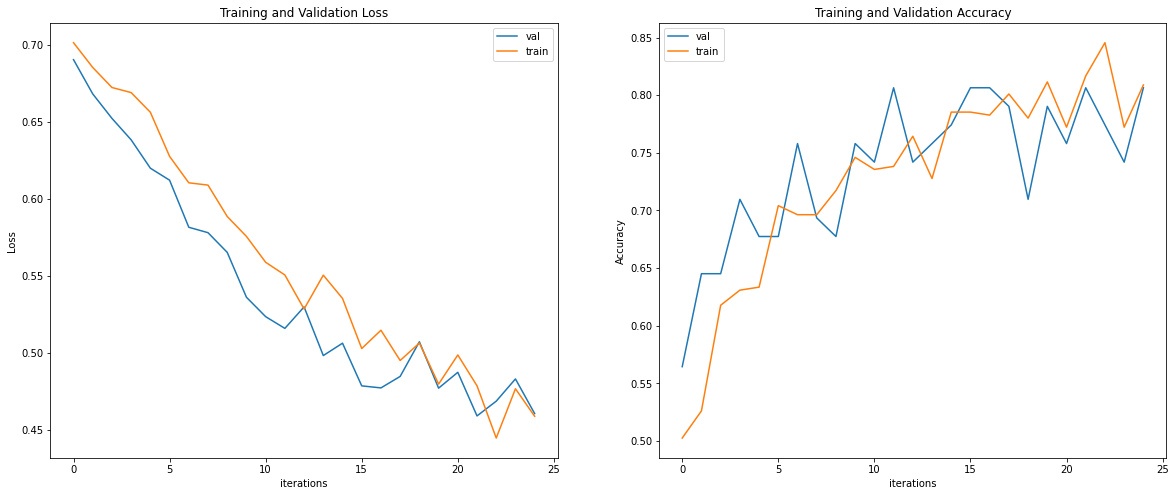

In [ ]:
plot_loss_acc ( train_losses_ft, train_acc_ft, val_losses_ft, val_acc_ft)

###Results -cat 5 as test:
####Finetune:
23/2
Batch size=4

with batch normalization parameter freeze, adam, decay: sqrt(10), results: 60% test, 77% val, ~92% train

without batch normalization, adam, decay: sqrt(10), results: 70% test, 74% val, ~92% train

again: results: 40% test, 76% val, ~92% train

27/2

without batch normalization, SGD, 2 fc layers (64,2), dropout(0.25), resnet50, results: 75% test, val 89%, train 95%<br>

same with resnet18: 75% test, val 90%, train 91%<br>

28/2
Renset18, 50 epochs, learning rate 0.0001, gamma=sqrt(0.1), step_size 15,patience 25: 80% test, val 88%, train 91%<br>
Renset18, 50 epochs, learning rate 0.0001, gamma=0.1, step_size=10, patience 15: 85% test, val 85%, train 84%<br>

####Transfer learning:
27/2
without batch normalization, SGD, 2 fc layers (64,2), dropout(0.25), resnet50, results: 55% test, val 89%, train 75%<br>
Same with resnet18: 70% test, 77% val, 77% train<br>
again: 60% test, 81% val, 67% train

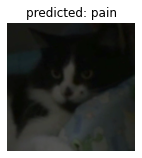

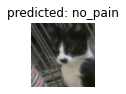

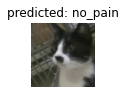

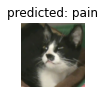

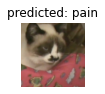

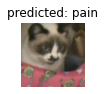

In [ ]:
visualize_model(model_ft, dataloaders ,class_names)

###b. Transfer learning  training- without cross validation

 
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [ ]:
pretrained_model2= models.resnet18
model_conv, criterion, optimizer_ft, exp_lr_scheduler =load_model(pretrained_model2, lr=0.001, flag_finetune=False)
model_conv, best_acc_conv, train_losses_conv, train_acc_conv, val_losses_conv, val_acc_conv = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,
                           dataloaders, dataset_sizes, num_epochs=25, patience=15)

Epoch 0/24
----------
train Loss: 0.7147 Acc: 0.4843
val Loss: 0.6930 Acc: 0.5161

Epoch 1/24
----------
train Loss: 0.6919 Acc: 0.5419
val Loss: 0.6811 Acc: 0.6129

Epoch 2/24
----------
train Loss: 0.6824 Acc: 0.5733
val Loss: 0.6741 Acc: 0.5645

Epoch 3/24
----------
train Loss: 0.6499 Acc: 0.6361
val Loss: 0.6888 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.6453 Acc: 0.6387
val Loss: 0.5983 Acc: 0.7258

Epoch 5/24
----------
train Loss: 0.6189 Acc: 0.6675
val Loss: 0.5789 Acc: 0.7097

Epoch 6/24
----------
train Loss: 0.6129 Acc: 0.6597
val Loss: 0.5427 Acc: 0.7258

Epoch 7/24
----------
train Loss: 0.6242 Acc: 0.6702
val Loss: 0.5106 Acc: 0.7903

Epoch 8/24
----------
train Loss: 0.5942 Acc: 0.7042
val Loss: 0.5190 Acc: 0.7903

Epoch 9/24
----------
train Loss: 0.6015 Acc: 0.6780
val Loss: 0.5161 Acc: 0.7903

Epoch 10/24
----------
train Loss: 0.5660 Acc: 0.7408
val Loss: 0.4843 Acc: 0.8065

Epoch 11/24
----------
train Loss: 0.5301 Acc: 0.7435
val Loss: 0.4827 Acc: 0.7742

Ep

In [ ]:
test_loss_conv, test_acc_conv = test_model(dataloaders['test'], model_conv, criterion)

Test error: 
Average loss: 0.16 test accuracy: 65.0% 



Plot:

ax1  AxesSubplot(0.125,0.125;0.352273x0.755)


(<matplotlib.axes._subplots.AxesSubplot at 0x7f6a22e0de50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a22c30850>)

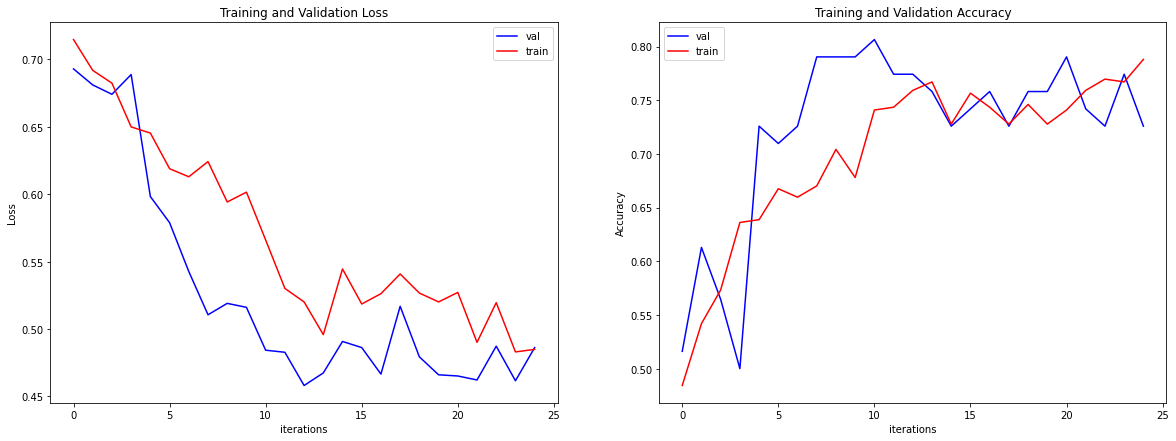

In [ ]:
plot_loss_acc ( train_losses_conv, train_acc_conv, val_losses_conv, val_acc_conv)

# Cross validation

One vs. all cross validation and train each time a new model. Run for all cats  - each time one cat in test, and n_val cats in validation.
Predict the test result for each cat, and return mean test accuracy.

In [ ]:
np.random.seed(42) # remove for random results!!!!!

def create_sets(image_paths, unique_inverse, val_index, test_index, n_val, n_images):
  # test
  test_mask= np.isin(unique_inverse, test_index)
  test_indexes = np.flatnonzero(test_mask) 
  test_paths = [image_paths[index] for index in test_indexes]
  # validation
  val_mask= np.isin(unique_inverse, val_index)
  val_indexes = np.flatnonzero(val_mask) 
  val_paths = [image_paths[index] for index in val_indexes]
  # train
  train_indexes = np.flatnonzero(np.logical_not(test_mask | val_mask)) 
  train_paths = [image_paths[index] for index in train_indexes]
  print(f'test fraction: {len(test_paths)/n_images: .2f}')
  print(f'validation fraction: {len(val_paths)/n_images: .2f}')
  print(f'train fraction: {len(train_paths)/n_images: .2f}')
  return {'train':train_paths, 'val': val_paths, 'test': test_paths}

def cross_validation_train(data_dir, output_dir, pretrained_model, n_val, batch_size, 
                           folder_names={'test', 'val', 'train'}, num_epochs=25, patience=10, lr=0.0001, finetune=True):
  since = time.time() 
  image_paths = list(paths.list_images(data_dir))
  n_images = len(image_paths)
  image_paths.sort()
  # build an array of cat/object numbers
  object_number_vec =np.array([int(re.search(r'-?\d+', path)[0]) for path in image_paths ]) 
  [object_number_unique, unique_inverse]= np.unique(object_number_vec, return_inverse=True)
  n_objects = len(object_number_unique)
  object_index_unique = np.unique(unique_inverse)  
  test_loss = np.zeros(n_objects)
  test_acc = np.zeros(n_objects)
  val_acc = np.zeros(n_objects)
  axes = None
  save_folder='/content/drive/MyDrive/models/'
  if not os.path.exists(save_folder):
    os.mkdir(save_folder)
  
  for k_object in [3,8]:# range(n_objects):# [3]:   # for testing replace n_objects to a number for only few cats, e.g. range(5)
      object_number= object_number_unique[k_object]
      print('\nCat number for test: ',object_number ,' index: ', k_object)
      # load initial weights
      #model.load_state_dict(torch.load(file_initial_weights))
      #model.to(device) 
      model, criterion, optimizer_ft, exp_lr_scheduler = load_model(pretrained_model, lr, finetune)
      # Create data loaders
      train_and_val = object_index_unique[object_index_unique != k_object]
      val_indexes = np.random.choice(train_and_val, n_val, replace=False)
      #val_indexes =[4,5,6,7]
      print('Validation cats: ', object_number_unique[val_indexes])
      dict_paths = create_sets(image_paths, unique_inverse, val_indexes, k_object, n_val, n_images)
      for name in folder_names:
        copy_images(dict_paths[name], os.path.join(output_dir, name))
      dataloaders, dataset_sizes, class_names = load_data(output_dir, batch_size, folder_names)
      dataloader_test = dataloaders.pop('test')
      # train
      model_best, val_acc[k_object],train_losses_, train_acc_, val_losses_, val_acc_vec  = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, 
                                dataloaders,dataset_sizes, num_epochs, patience)
      # test
      test_loss[k_object], test_acc[k_object] = test_model(dataloader_test, model_best, criterion)
      # plot
      axes = plot_loss_acc(train_losses_, train_acc_, val_losses_, val_acc_vec, axes)

      # Calculate and print accuracy means
      val_acc_mean = val_acc[np.nonzero(val_acc)].mean()
      test_acc_mean = test_acc[np.nonzero(test_acc)].mean()
      print(f'\nMean validation accuracy till {k_object+1}: {100*val_acc_mean:.2f}%')
      print(f'Mean test accuracy till {k_object+1}: {100*test_acc_mean:.2f}%')
      # Save model
      model_file_name =f'/content/drive/MyDrive/models/model{k_object}_cat{object_number}_test_ac{100*test_acc[k_object]:.0f}.pth'
      torch.save(model.state_dict(), model_file_name)
      print('Saved PyTorch model state to ', model_file_name)
  time_elapsed = time.time() - since
  print(f'\nCross validation finished, time elappsed {time_elapsed // 60 :.0f}m {time_elapsed % 60 : .0f}s')
  #model.load_state_dict(initial_model_wts)
  test_acc_mean = test_acc[np.nonzero(test_acc)].mean()
  print(f'Total mean test accuracy: {100*test_acc_mean:.2f}%')
  return test_loss, test_acc, val_acc

##a. Finetune training with cross validation

In [ ]:
n_val = 4 
data_folder = '/content/drive/MyDrive/cats'
output_dir = '/content/'
batch_size = 4
test_loss_ft, test_acc_ft, val_acc_ft=cross_validation_train(data_folder, output_dir, models.resnet18, 
                        n_val, batch_size, num_epochs=35, patience=15, finetune=True)


Cat number for test:  1  index:  0
Validation cats:  [11 21  3 29]
test fraction:  0.02
validation fraction:  0.11
train fraction:  0.88
{'train': 406, 'val': 50, 'test': 8}
Epoch 0/34
----------
train Loss: 0.7052 Acc: 0.4951
val Loss: 0.7045 Acc: 0.5200

Epoch 1/34
----------
train Loss: 0.6754 Acc: 0.5936
val Loss: 0.6915 Acc: 0.5600

Epoch 2/34
----------
train Loss: 0.6552 Acc: 0.6502
val Loss: 0.6859 Acc: 0.5200

Epoch 3/34
----------
train Loss: 0.6431 Acc: 0.6330
val Loss: 0.6724 Acc: 0.6000

Epoch 4/34
----------
train Loss: 0.6267 Acc: 0.6847
val Loss: 0.6772 Acc: 0.5000

Epoch 5/34
----------
train Loss: 0.6025 Acc: 0.7217
val Loss: 0.6691 Acc: 0.5600

Epoch 6/34
----------
train Loss: 0.5934 Acc: 0.7340
val Loss: 0.6263 Acc: 0.6400

Epoch 7/34
----------
train Loss: 0.5689 Acc: 0.7217
val Loss: 0.6469 Acc: 0.6200

Epoch 8/34
----------
train Loss: 0.5606 Acc: 0.7266
val Loss: 0.6852 Acc: 0.5600

Epoch 9/34
----------
train Loss: 0.5110 Acc: 0.8030
val Loss: 0.6935 Acc: 0.5

Results:

For the first 14 cats with SGD, 1 fc layer: 54% accuracy on test (regular mean). Tamar 22.2.22 17:00

For the first 24 cats with SGD, resnet18, 2 fc layer: 52% accuracy on test, 52% accuracy on validation (regular mean). Tamar and Itay 27.2.22 13:00

Cat 5 as test (no CV):<br>  
cats 6,7,8,9 validation, with SGD, resnet18, 2 fc layer: 60% accuracy on test, 85% accuracy on validation (regular mean). Tamar  27.2.22 16:20

cats 11, 21, 1, 29 validation, with SGD, resnet18, 2 fc layer: 65% accuracy on test, 74% accuracy on validation (regular mean). Tamar  27.2.22 17:00



##b. Transfer learning with cross validation

###Resnet18


Cat number for test:  5  index:  3
Validation cats:  [ 1 20 18 10]
test fraction:  0.04
validation fraction:  0.13
train fraction:  0.82
{'test': 20, 'train': 382, 'val': 62}
Epoch 0/49
----------
train Loss: 0.7058 Acc: 0.5000
val Loss: 0.7060 Acc: 0.4194

Epoch 1/49
----------
train Loss: 0.6870 Acc: 0.5602
val Loss: 0.6975 Acc: 0.4839

Epoch 2/49
----------
train Loss: 0.6828 Acc: 0.5602
val Loss: 0.6915 Acc: 0.5161

Epoch 3/49
----------
train Loss: 0.6766 Acc: 0.5654
val Loss: 0.6937 Acc: 0.4355

Epoch 4/49
----------
train Loss: 0.6704 Acc: 0.5707
val Loss: 0.6896 Acc: 0.5968

Epoch 5/49
----------
train Loss: 0.6738 Acc: 0.5995
val Loss: 0.6885 Acc: 0.5000

Epoch 6/49
----------
train Loss: 0.6661 Acc: 0.6283
val Loss: 0.6890 Acc: 0.4839

Epoch 7/49
----------
train Loss: 0.6683 Acc: 0.6230
val Loss: 0.6871 Acc: 0.5161

Epoch 8/49
----------
train Loss: 0.6541 Acc: 0.6361
val Loss: 0.6851 Acc: 0.5323

Epoch 9/49
----------
train Loss: 0.6621 Acc: 0.6230
val Loss: 0.6768 Acc: 0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


train Loss: 0.6439 Acc: 0.6351
val Loss: 0.6666 Acc: 0.5811

Epoch 23/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6145 Acc: 0.7054


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.6558 Acc: 0.6351

Epoch 24/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6204 Acc: 0.6811


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.6569 Acc: 0.5811

Epoch 25/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6103 Acc: 0.7081


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.6504 Acc: 0.5946

Epoch 26/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6213 Acc: 0.6757


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

val Loss: 0.6601 Acc: 0.5946

Epoch 27/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

train Loss: 0.5947 Acc: 0.7189


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6541 Acc: 0.6216

Epoch 28/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

train Loss: 0.6188 Acc: 0.6946


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6600 Acc: 0.5811

Epoch 29/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6081 Acc: 0.6946


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6561 Acc: 0.5676

Epoch 30/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6058 Acc: 0.6892


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6654 Acc: 0.5811

Epoch 31/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6082 Acc: 0.7162


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6583 Acc: 0.5811

Epoch 32/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6041 Acc: 0.6919


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6529 Acc: 0.6081

Epoch 33/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6118 Acc: 0.7162


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6675 Acc: 0.5811

Epoch 34/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6105 Acc: 0.6865


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6454 Acc: 0.6351

Epoch 35/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.6061 Acc: 0.7162


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6532 Acc: 0.6216

Epoch 36/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.5978 Acc: 0.7081


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

val Loss: 0.6393 Acc: 0.5811

Epoch 37/49
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6acc299440>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child

train Loss: 0.6113 Acc: 0.6676
val Loss: 0.6503 Acc: 0.5946

Epoch 38/49
----------
train Loss: 0.6139 Acc: 0.6838
val Loss: 0.6476 Acc: 0.6081

Epoch 39/49
----------
train Loss: 0.5917 Acc: 0.7108
val Loss: 0.6649 Acc: 0.5676

Epoch 40/49
----------
train Loss: 0.5837 Acc: 0.7459
val Loss: 0.6523 Acc: 0.6216

Epoch 41/49
----------
train Loss: 0.5983 Acc: 0.7243
val Loss: 0.6602 Acc: 0.5811

Epoch 42/49
----------
train Loss: 0.5983 Acc: 0.7297
val Loss: 0.6459 Acc: 0.6351

Epoch 43/49
----------
train Loss: 0.6146 Acc: 0.6514
val Loss: 0.6448 Acc: 0.6081

Training complete in 9m 20s
Best val Acc: 0.635135
Test error: 
Average loss: 0.15 test accuracy: 70.0% 

AxesSubplot(0.547727,0.125;0.352273x0.755)

Mean validation accuracy till 9: 65.63%
Mean test accuracy till 9: 62.50%
Saved PyTorch model state to  /content/drive/MyDrive/models/model8_cat10_test_ac70.pth

Cross validation finished, time elappsed 17m  11s
Total mean test accuracy: 62.50%


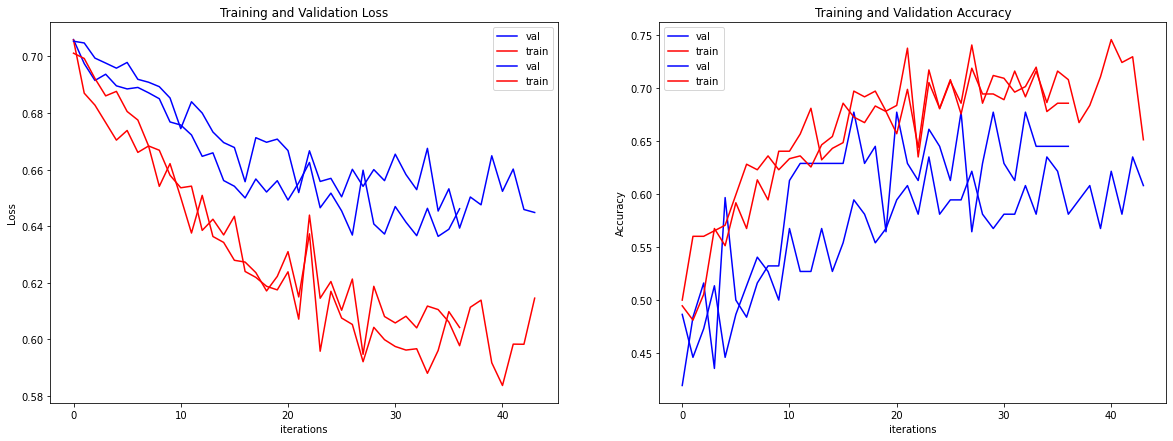

In [ ]:
#model_conv
n_val = 4 
data_folder = '/content/drive/MyDrive/cats'
output_dir = '/content/'
batch_size_tl = 4
test_loss_tl18, test_acc_tl18, val_acc_tl18=cross_validation_train(data_folder, output_dir, models.resnet18, n_val, batch_size_tl, num_epochs=50, patience=20,lr=0.0001, finetune=False)


###Resnet50


In [ ]:
#model_conv
batch_size_tl = 64
pretrained_model_50 = models.resnet50
test_loss_tl50, test_acc_tl50, val_acc_tl50=cross_validation_train(data_folder, output_dir, pretrained_model_50,
                                                                   n_val, batch_size_tl, num_epochs=25, finetune=False)


Cat number for test:  1  index:  0
Validation cats:  [11 21  3 29]
test fraction:  0.02
validation fraction:  0.11
train fraction:  0.88
{'test': 8, 'val': 50, 'train': 406}
Epoch 0/24
----------
train Loss: 0.6840 Acc: 0.5813
val Loss: 0.6251 Acc: 0.7400

Epoch 1/24
----------
train Loss: 0.6308 Acc: 0.6453
val Loss: 0.6210 Acc: 0.6600

Epoch 2/24
----------
train Loss: 0.6045 Acc: 0.7044
val Loss: 0.6296 Acc: 0.6600

Epoch 3/24
----------
train Loss: 0.5801 Acc: 0.7365
val Loss: 0.6454 Acc: 0.5800

Epoch 4/24
----------
train Loss: 0.5484 Acc: 0.7709
val Loss: 0.6580 Acc: 0.5600

Epoch 5/24
----------
train Loss: 0.5353 Acc: 0.7808
val Loss: 0.6726 Acc: 0.5400

Epoch 6/24
----------
train Loss: 0.5205 Acc: 0.7931
val Loss: 0.6630 Acc: 0.6400

Epoch 7/24
----------
train Loss: 0.5111 Acc: 0.7980
val Loss: 0.6654 Acc: 0.6400

Epoch 8/24
----------
train Loss: 0.4977 Acc: 0.8103
val Loss: 0.6814 Acc: 0.6000

Epoch 9/24
----------
train Loss: 0.4901 Acc: 0.8005
val Loss: 0.6760 Acc: 0.6

###New results:

Parameters - full run (27 cats):
Resnet18:
* seed = 42
* batch_size_tl = 4
* SGD with momentum 0.9
* lr = 0.0001
* Lr decay: step_size=10, gamma=np.sqrt(0.1)
* epochs=35
* Left- right augmentation
* early stopping: paticence=15

Finetune:
Mean validation accuracy till 27: 78.52%
Mean test accuracy till 27: 74.64%
Saved PyTorch model state to  /content/drive/MyDrive/models/model26_cat30_test_ac61.pth
Cross validation finished, time elappsed 213m  6s

Transfer learning (24 cats):
Test: 68.5%
Need to run again with larger learning rate

Old results - one cat:

Resnet18 Transfer learning:
* seed = 42
* batch_size_tl = 16
* Adam
* epochs=25
* lr = 0.001
* step_size=4

Cat 4:
* Validation accuracy:75.5%
* Test accuracy: 75%

Cat 6:
* Validation accuracy:74.3%
* Test accuracy: 77%

Parameters:
* lr = 0.001/2
* step_size=14
Cat 6:
* Validation accuracy:72.2%
* Test accuracy: 77.3%


Resnet50 Transfer learning:
* seed = 42 
* batch_size_tl = 64
* Adam
* lr = 0.001/2
* step_size=14
* epochs=25

Cat 4:
* Test accuracy: 75%
* Validation accuracy:72.5%

Cat 6:
* Test accuracy: 68.5%
* Validation accuracy:90.9%

## To do list
- add fc layer of input/8 to resnet18 (done)
- add dropout 0.25 (done)
- train/val loss graph (itai)
- Adam vs SGD optimization - SGD chosen
- decay lr when val reach saturation (done - does not improve)
- Full training vs. last layer (currently 87% vs 79% without CV)
- Resnet18 vs ResNet50
- 2 classes to 1 0-1 class and binarycrossentropy
- Table of results
- Confusion matrix
- Brightness augmentation

- Transfer learning from Dino (tamar)
- visualization of results